<a href="https://colab.research.google.com/github/nicolai5965/CustomCNN_on_MNIST_dataset/blob/main/MNIST_CustomCNN_Prediction_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Loading the MNIST dataset from TensorFlow´s datasets

In [ ]:
# Load the dataset
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


Pre processing of the data, and splitting the data up in training, validation and testing datasets. 

In [ ]:

# Defining a function to scale the images in the dataset
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255.
  return image, label

# Scaling and batching the training and validation datasets
batch_size = 64


In [ ]:
# Load the dataset
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True, split='train[:2000]+test[:500]')

# Set the number of samples for training, validation, and testing
num_train_samples = 100
num_validation_samples = 10
num_test_samples = 20
# Splitting the MNIST dataset into training and testing sets
mnist_train = mnist_dataset.take(num_train_samples)
mnist_test = mnist_dataset.skip(num_train_samples).take(num_test_samples)
# Shuffle the training dataset
mnist_train = mnist_train.shuffle(num_train_samples, seed=42)

# Scale and batch the training and validation datasets
scaled_train_and_validation_data = mnist_train.map(scale)
train_data = scaled_train_and_validation_data.skip(num_validation_samples).batch(batch_size).prefetch(1)
validation_data = scaled_train_and_validation_data.take(num_validation_samples).batch(num_validation_samples)
test_data = mnist_test.map(scale).batch(num_test_samples)

# Extract the inputs and targets from the validation dataset
validation_inputs, validation_targets = next(iter(validation_data))


In [ ]:
# Print the shapes of the training, validation, and test sets
print("Training data shape:", train_data.element_spec)
print("Validation data shape:", validation_data.element_spec)
print("Test data shape:", test_data.element_spec)

Training data shape: (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
Validation data shape: (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
Test data shape: (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


In [ ]:
def apply_padding(x, padding, kernel_height, kernel_width, strides):
    batch_size, input_height, input_width, _ = x.shape

    if padding == 'VALID':
        pad_rows = 0
        pad_cols = 0
    elif padding == 'SAME':
        pad_rows = max((input_height - 1) * strides[0] + kernel_height - input_height, 0)
        pad_cols = max((input_width - 1) * strides[1] + kernel_width - input_width, 0)

    pad_top = pad_rows // 2
    pad_bottom = pad_rows - pad_top
    pad_left = pad_cols // 2
    pad_right = pad_cols - pad_left

    x_padded = tf.pad(x, [[0, 0], [pad_top, pad_bottom], [pad_left, pad_right], [0, 0]])

    return x_padded, pad_rows, pad_cols

In [ ]:
def conv2d_explicit(x, kernel, strides=(1, 1), padding='VALID'):
    input_shape = tf.shape(x)
    batch_size, input_height, input_width, in_channels = input_shape[0], input_shape[1], input_shape[2], input_shape[3]

    filter_height, filter_width, _, out_channels = kernel.shape
    
    x_padded, pad_rows, pad_cols = apply_padding(x, padding, filter_height, filter_width, strides)

    output_height = (input_height + pad_rows - filter_height) // strides[0] + 1
    output_width = (input_width + pad_cols - filter_width) // strides[1] + 1

    output = tf.zeros((batch_size, output_height, output_width, out_channels), dtype=tf.float32)

    for h in range(output_height):
        for w in range(output_width):
            for c_out in range(out_channels):
                input_slice = x_padded[:, 
                                       h * strides[0]:h * strides[0] + filter_height, 
                                       w * strides[1]:w * strides[1] + filter_width, :]
                kernel_slice = kernel[:, :, :, c_out]
                output_slice = tf.reduce_sum(input_slice * kernel_slice, axis=[1, 2, 3])
                output = tf.tensor_scatter_nd_add(output,
                                                  indices=tf.stack([tf.range(batch_size), 
                                                                    tf.ones(batch_size, dtype=tf.int32) * h, 
                                                                    tf.ones(batch_size, dtype=tf.int32) * w, 
                                                                    tf.ones(batch_size, dtype=tf.int32) * c_out], axis=-1),
                                                  updates=output_slice)
    return output

In [ ]:
class CustomConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=(1, 1), padding='VALID', activation=None, use_l2_reg=False, l2_reg_rate=0.001, use_batch_norm=False, **kwargs):
        super(CustomConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.activation = tf.keras.activations.get(activation)
        self.use_l2_reg = use_l2_reg
        self.l2_reg_rate = l2_reg_rate
        self.use_batch_norm = use_batch_norm
        if self.use_batch_norm:
            self.batch_norm = BatchNormalization()

    def build(self, input_shape):
        if self.use_l2_reg:
            self.kernel = self.add_weight("kernel",
                                          shape=(self.kernel_size[0], self.kernel_size[1], input_shape[-1], self.filters),
                                          initializer="glorot_uniform",
                                          trainable=True,
                                          regularizer=regularizers.l2(self.l2_reg_rate))
        else:
            self.kernel = self.add_weight("kernel",
                                          shape=(self.kernel_size[0], self.kernel_size[1], input_shape[-1], self.filters),
                                          initializer="glorot_uniform",
                                          trainable=True)

    def call(self, inputs):
        output = conv2d_explicit(inputs, self.kernel, strides=self.strides, padding=self.padding)
        if self.use_batch_norm:
            output = self.batch_norm(output)
        if self.activation is not None:
            output = self.activation(output)
        return output


In [ ]:

def max_pooling2d_explicit(x, pool_size=(2, 2), strides=(2, 2), padding='VALID'):
    input_shape = tf.shape(x)
    batch_size, input_height, input_width, in_channels = input_shape[0], input_shape[1], input_shape[2], input_shape[3]

    pool_height, pool_width = pool_size

    x_padded, pad_rows, pad_cols = apply_padding(x, padding, input_height, input_width, strides)

    output_height = (input_height + pad_rows - pool_height) // strides[0] + 1
    output_width = (input_width + pad_cols - pool_width) // strides[1] + 1

    output = tf.zeros((batch_size, output_height, output_width, in_channels), dtype=tf.float32)

    for h in range(output_height):
        for w in range(output_width):
            input_slice = x_padded[:, 
                                   h * strides[0]:h * strides[0] + pool_height, 
                                   w * strides[1]:w * strides[1] + pool_width, :]
            output_slice = tf.reduce_max(input_slice, axis=[1, 2])
            output = tf.tensor_scatter_nd_add(output,
                                              indices=tf.stack([tf.range(batch_size), 
                                                                tf.ones(batch_size, dtype=tf.int32) * h, 
                                                                tf.ones(batch_size, dtype=tf.int32) * w], axis=-1),
                                              updates=output_slice)
    return output

In [ ]:
class CustomMaxPooling2D(tf.keras.layers.Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding='VALID', **kwargs):
        super(CustomMaxPooling2D, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding

    def call(self, inputs):
        return max_pooling2d_explicit(inputs, pool_size=self.pool_size, strides=self.strides, padding=self.padding)


In [ ]:

# Creating the model
model = Sequential([
    CustomConv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='SAME', activation='relu', use_l2_reg=True, l2_reg_rate=0.001, use_batch_norm=True, input_shape=(28, 28, 1)),
    CustomMaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='VALID'),
    CustomConv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='SAME', activation='relu', use_l2_reg=True, l2_reg_rate=0.001, use_batch_norm=True),
    CustomMaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='VALID'),
    Flatten(),
    Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(units=10, activation='softmax')
])

# Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=(validation_inputs, validation_targets), verbose=2)

# Evaluating the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_data)
print("Test loss: {0:.4f}, test accuracy: {1:.4f}".format(test_loss, test_accuracy))

Epoch 1/5
2/2 - 101s - loss: 3.8302 - accuracy: 0.0778 - val_loss: 2.5357 - val_accuracy: 0.3000 - 101s/epoch - 50s/step
Epoch 2/5
2/2 - 29s - loss: 3.2905 - accuracy: 0.2889 - val_loss: 2.4779 - val_accuracy: 0.5000 - 29s/epoch - 14s/step
Epoch 3/5
2/2 - 34s - loss: 2.5368 - accuracy: 0.5000 - val_loss: 2.4503 - val_accuracy: 0.6000 - 34s/epoch - 17s/step
Epoch 4/5
2/2 - 29s - loss: 1.6486 - accuracy: 0.6556 - val_loss: 2.4230 - val_accuracy: 0.6000 - 29s/epoch - 14s/step
Epoch 5/5
2/2 - 30s - loss: 1.3548 - accuracy: 0.6667 - val_loss: 2.3814 - val_accuracy: 0.8000 - 30s/epoch - 15s/step
1/1 [==============================] - 3s 3s/step - loss: 2.4144 - accuracy: 0.6000
Test loss: 2.4144, test accuracy: 0.6000


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2D  (None, 28, 28, 32)       416       
 )                                                               
                                                                 
 custom_max_pooling2d (Custo  (None, 14, 14, 32)       0         
 mMaxPooling2D)                                                  
                                                                 
 custom_conv2d_1 (CustomConv  (None, 14, 14, 64)       18688     
 2D)                                                             
                                                                 
 custom_max_pooling2d_1 (Cus  (None, 7, 7, 64)         0         
 tomMaxPooling2D)                                                
                                                                 
 flatten (Flatten)           (None, 3136)              0

In [ ]:
def plot_loss_and_accuracy_curves(history):
    plt.figure(figsize=(12, 4))

    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')

    plt.show()

def plot_confusion_matrix(test_data, model):
    y_true = np.concatenate([y for x, y in test_data], axis=0)
    y_pred = np.argmax(model.predict(test_data), axis=1)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def plot_feature_maps(model, test_data):
    feature_map_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[0].output)

    image, _ = next(iter(test_data.take(1)))
    image = image[0:1]

    feature_maps = feature_map_model.predict(image)

    num_feature_maps = feature_maps.shape[-1]
    rows = int(np.sqrt(num_feature_maps))
    cols = int(np.ceil(num_feature_maps / rows))

    plt.figure(figsize=(cols * 2, rows * 2))

    for i in range(num_feature_maps):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(feature_maps[0, :, :, i], cmap='gray')
        plt.axis('off')

    plt.suptitle('Feature Maps')
    plt.show()


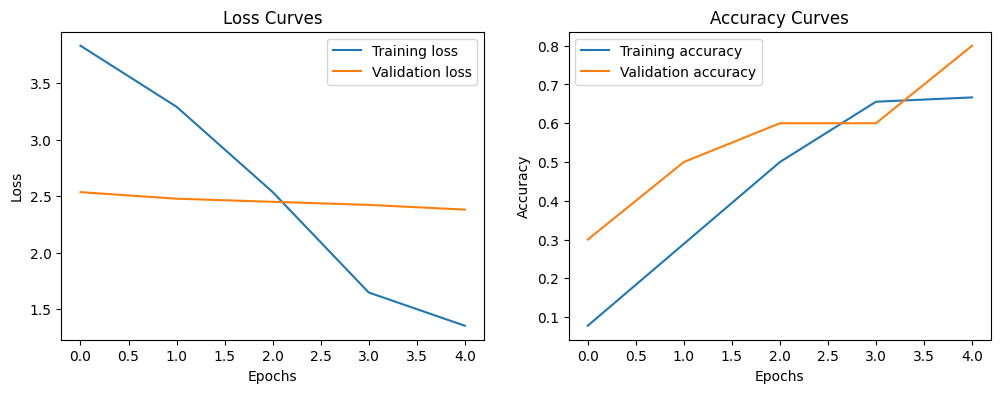

1/1 [==============================] - 8s 8s/step


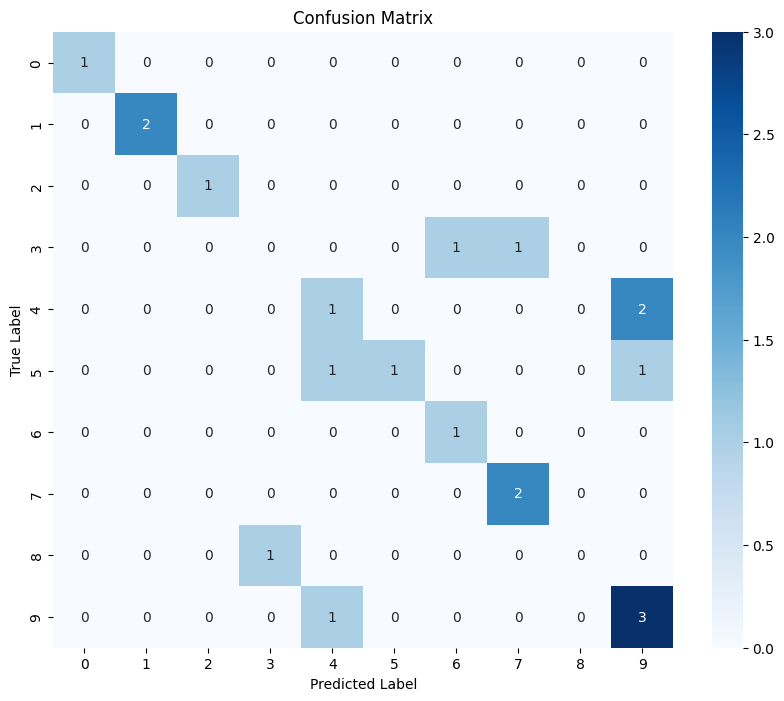

1/1 [==============================] - 2s 2s/step


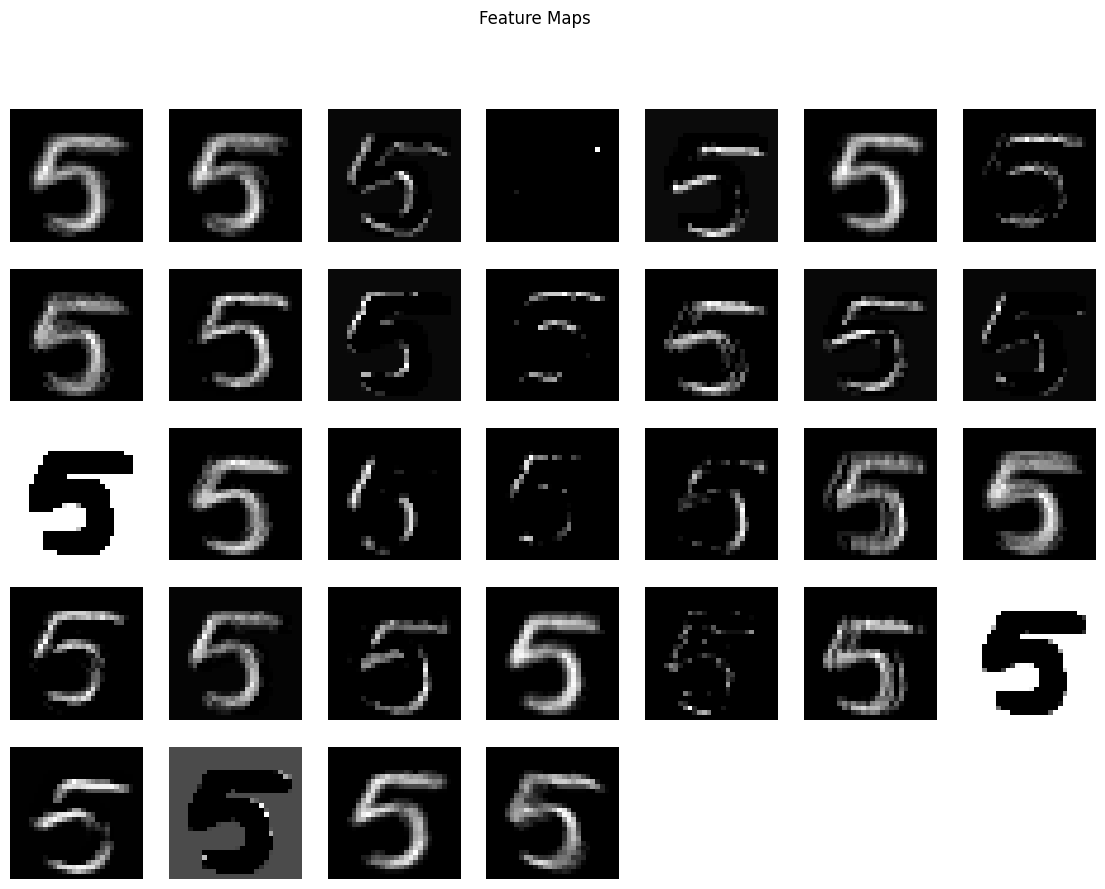

In [ ]:

# Plot the loss and accuracy curves
plot_loss_and_accuracy_curves(history)

# Plot the confusion matrix
plot_confusion_matrix(test_data, model)

# Plot the feature maps
plot_feature_maps(model, test_data)